In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
#from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_auc
from sklearn.metrics import auc
### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')


### Set randome seed
seed = 10 
np.random.seed(seed)


## Reading and Processing the Data

In [2]:
data1 = pd.read_csv('11-25-20 - Normal Operation - 24 plates.csv', sep=",", na_values=["N/A - Likely previous sequence's safe point"], engine="python")
print(data1.head(5))
print(data1.shape)


                Time             Sequence Name Expected Location Name  \
0  11-25-20 12-41-33  Get From Hotel - Shelf 1                    NaN   
1  11-25-20 12-41-40  Get From Hotel - Shelf 1     Hotel Shelf 1 Nest   
2  11-25-20 12-41-48         Put Plate On Wasp              Wasp Nest   
3  11-25-20 12-41-52       Get Plate From Wasp                    NaN   
4  11-25-20 12-41-55       Get Plate From Wasp              Wasp Nest   

                       Expected Location  \
0                                    NaN   
1   287.0911, 29.3043, 415.9264, 13.7549   
2  265.5565, 84.0547, 421.2137, 358.0884   
3                                    NaN   
4  265.5565, 84.0547, 421.2137, 358.0884   

                          Actual Location  Gripper Force (%)  \
0     274.8786, 350.1495, 182.447, 27.312                  0   
1    287.0895, 29.3001, 415.9102, 13.7988                100   
2   265.5584, 84.0657, 421.2216, 358.0225                100   
3  274.1419, 259.3527, 228.7065, 349.782

In [3]:

Expected_Location1=data1["Expected Location"].str.split(pat=",", n=4, expand=True)
#print(Expected_Location1)
Actual_Location1=data1["Actual Location"].str.split(pat=",", n=4, expand=True)
#print(Actual_Location1)
Motor_Current1=data1["Motor Current (A) (axis 1,2,3,4)"].str.split(pat=",", n=4, expand=True)
#print(Motor_Current1)

data1["Expected_Location_X"]=pd.to_numeric(Expected_Location1[0])

data1["Expected_Location_Y"]=pd.to_numeric(Expected_Location1[1])
data1["Expected_Location_Z"]=pd.to_numeric(Expected_Location1[2])
data1["Expected_Location_Theta"]=pd.to_numeric(Expected_Location1[3])

data1["Actual_Location_X"]=pd.to_numeric(Actual_Location1[0])

data1["Actual_Location_Y"]=pd.to_numeric(Actual_Location1[1])
data1["Actual_Location_Z"]=pd.to_numeric(Actual_Location1[2])
data1["Actual_Location_Theta"]=pd.to_numeric(Actual_Location1[3])

data1["Motor_Current_X"]=pd.to_numeric(Motor_Current1[0])
data1["Motor_Current_Y"]=pd.to_numeric(Motor_Current1[1])
data1["Motor_Current_Z"]=pd.to_numeric(Motor_Current1[2])
data1["Motor_Current_Theta"]=pd.to_numeric(Motor_Current1[3])
df1=data1.drop(columns=["Expected Location","Actual Location","Motor Current (A) (axis 1,2,3,4)"], axis=1)
#print(df1)
print(df1.shape)


(8280, 18)


In [4]:
data2 = pd.read_csv('11-30-20 - Simulated Degradation - 9 plates.csv', sep=",", na_values=["N/A - Likely previous sequence's safe point"], engine="python")
print(data2.head(5))
print(data2.shape)

                Time             Sequence Name Expected Location Name  \
0  11-30-20 09-16-50  Get From Hotel - Shelf 1                    NaN   
1  11-30-20 09-16-57  Get From Hotel - Shelf 1     Hotel Shelf 1 Nest   
2  11-30-20 09-17-04         Put Plate On Wasp              Wasp Nest   
3  11-30-20 09-17-08       Get Plate From Wasp                    NaN   
4  11-30-20 09-17-11       Get Plate From Wasp              Wasp Nest   

                       Expected Location  \
0                                    NaN   
1   287.0911, 29.3043, 415.9264, 13.7549   
2  265.5565, 84.0547, 421.2137, 358.0884   
3                                    NaN   
4  265.5565, 84.0547, 421.2137, 358.0884   

                          Actual Location  Gripper Force (%)  \
0    274.8774, 350.1558, 182.3931, 27.312                  0   
1    287.0885, 29.2978, 415.9091, 13.8428                100   
2   265.5588, 84.0782, 421.2174, 358.0664                100   
3  274.1422, 259.3509, 228.7034, 349.738

In [5]:
Expected_Location2=data2["Expected Location"].str.split(pat=",", n=4, expand=True)
#print(Expected_Location2)
Actual_Location2=data2["Actual Location"].str.split(pat=",", n=4, expand=True)
#print(Actual_Location2)
Motor_Current2=data2["Motor Current (A) (axis 1,2,3,4)"].str.split(pat=",", n=4, expand=True)
#print(Motor_Current2)

data2["Expected_Location_X"]=pd.to_numeric(Expected_Location2[0])

data2["Expected_Location_Y"]=pd.to_numeric(Expected_Location2[1])
data2["Expected_Location_Z"]=pd.to_numeric(Expected_Location2[2])
data2["Expected_Location_Theta"]=pd.to_numeric(Expected_Location2[3])

data2["Actual_Location_X"]=pd.to_numeric(Actual_Location2[0])

data2["Actual_Location_Y"]=pd.to_numeric(Actual_Location2[1])
data2["Actual_Location_Z"]=pd.to_numeric(Actual_Location2[2])
data2["Actual_Location_Theta"]=pd.to_numeric(Actual_Location2[3])

data2["Motor_Current_X"]=pd.to_numeric(Motor_Current2[0])
data2["Motor_Current_Y"]=pd.to_numeric(Motor_Current2[1])
data2["Motor_Current_Z"]=pd.to_numeric(Motor_Current2[2])
data2["Motor_Current_Theta"]=pd.to_numeric(Motor_Current2[3])
df2=data2.drop(columns=["Expected Location","Actual Location","Motor Current (A) (axis 1,2,3,4)"], axis=1)

#print(df2)
print(df2.shape)


(4897, 18)


In [6]:

df1=df1.dropna(subset=['Expected_Location_X'])
print(df1.shape)
print(df1)

df2=df2.dropna(subset=["Expected_Location_X"])

print(df2.shape)
print(df2)

(5520, 18)
                   Time             Sequence Name Expected Location Name  \
1     11-25-20 12-41-40  Get From Hotel - Shelf 1     Hotel Shelf 1 Nest   
2     11-25-20 12-41-48         Put Plate On Wasp              Wasp Nest   
4     11-25-20 12-41-55       Get Plate From Wasp              Wasp Nest   
5     11-25-20 12-42-00       Put Plate On Wasp 2            Wasp 2 Nest   
7     11-25-20 12-42-10  Get From Hotel - Shelf 2     Hotel Shelf 2 Nest   
...                 ...                       ...                    ...   
8273  11-25-20 12-54-27   Put In Hotel - Shelf 22         Hotel Shelf 22   
8275  11-25-20 12-54-37     Get Plate From Wasp 2            Wasp 2 Nest   
8276  11-25-20 12-54-43       Put Plate On Wasp 3            Wasp 3 Nest   
8278  11-25-20 12-54-50     Get Plate From Wasp 3            Wasp 3 Nest   
8279  11-25-20 12-54-58   Put In Hotel - Shelf 23         Hotel Shelf 23   

      Gripper Force (%)  Error Message      Note(s)  Expected_Location_X  \


# Plotting graphs, prediction and metrics for various columns in the data

# Expected Location Actual Location 

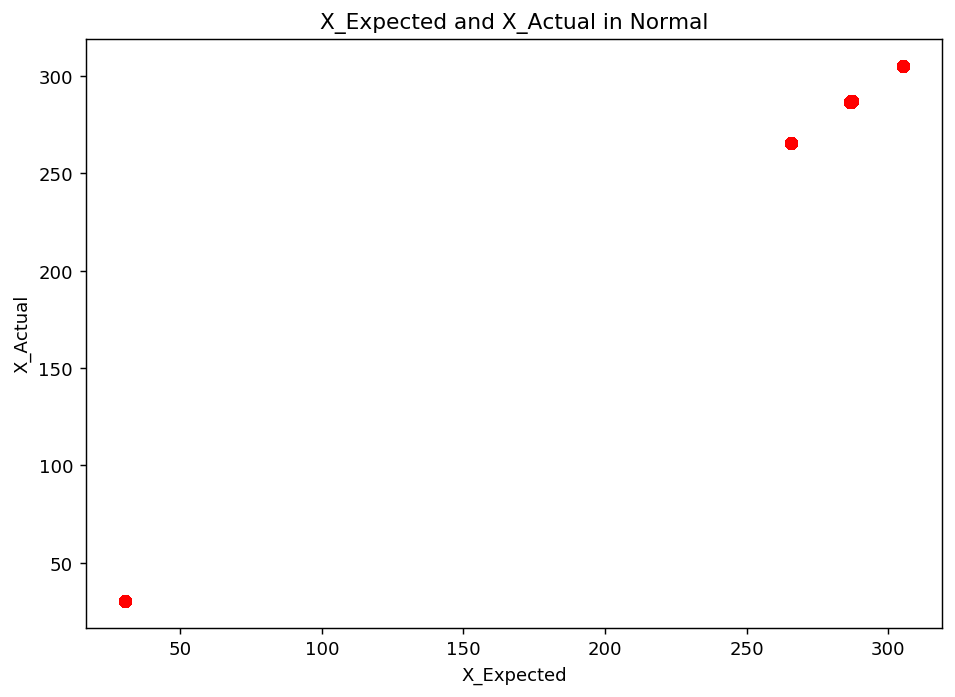

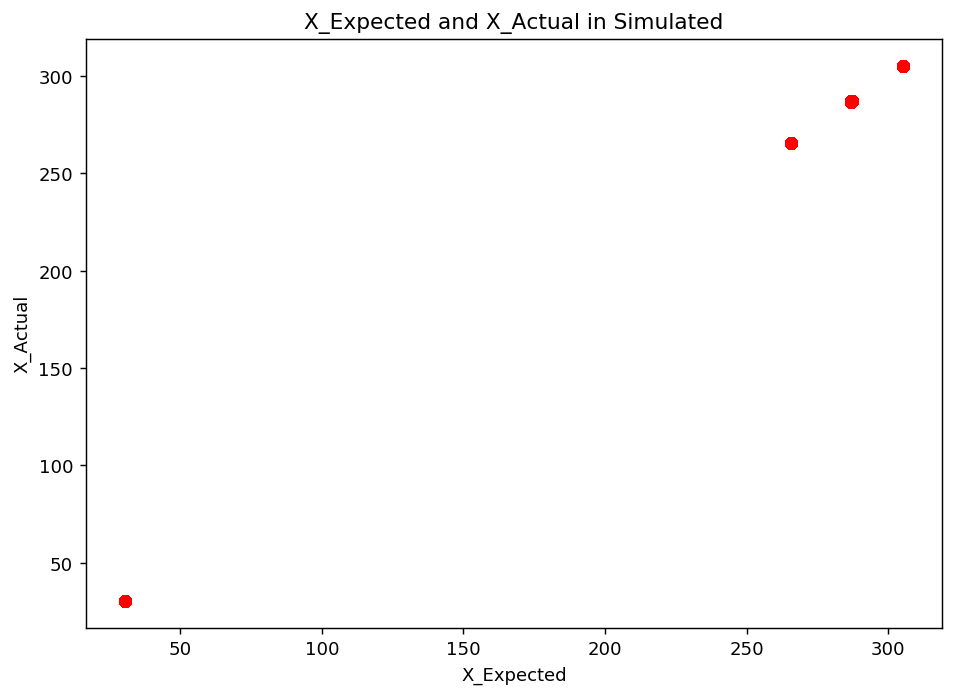

In [7]:
#Drawing graph between X and Y for normal data and simulated data
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Expected_Location_X"], df1["Actual_Location_X"], 'ro' )
           

ax.set_title('X_Expected and X_Actual in Normal')
ax.set_xlabel('X_Expected')
ax.set_ylabel('X_Actual')

#ax.legend()

plt.show()


fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df2["Expected_Location_X"], df2["Actual_Location_X"], 'ro' )
           

ax.set_title('X_Expected and X_Actual in Simulated')
ax.set_xlabel('X_Expected')
ax.set_ylabel('X_Actual')

#ax.legend()

plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df1["Expected_Location_X"], df1["Actual_Location_X"],test_size=0.5,random_state=seed)

X_train=X_train.to_frame()

XX_train=np.c_[X_train, y_train]
#print(XX_train)


#print(df2["Expected_Location_X"].shape)
frames_X=[X_test, df2["Expected_Location_X"]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test, df2["Actual_Location_X"]]
y_test_combo=pd.concat(frames_y, axis=0)
#print(X_test_combo)
X_test_combo=X_test_combo.to_frame()
y_test_combo=y_test_combo.to_frame()
#print(X_test_combo.shape)
#print(y_test_combo.shape)

XX_test_combo=np.c_[X_test_combo, y_test_combo]
#print(XX_test_combo)
#Build target variable
n2=X_test.shape[0]
#print(n2)
n3=df2["Expected_Location_X"].shape[0]
#print(n3)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

y3=np.ones(n3, dtype=int)*(-1)
#print(y3.shape)
y_actual_test=np.r_[y2,y3]
#print(y_test.shape)

# fit the model X_Expected
isf=IsolationForest()
isf.fit(X_train)
 #predict values
y_pred_train=isf.fit_predict(X_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(X_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both X_Expected and X_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 



[-1 -1 -1 ... -1 -1 -1]
[-1 -1 -1 ... -1 -1 -1]
0.4807436918990704
0.242296918767507
0.06268115942028986
0.448466805200341
[[2723  541]
 [2587  173]]
[-1 -1 -1 ... -1 -1  1]
[ 1 -1  1 ... -1  1 -1]
0.4404050464807437
0.40273798153454315
0.4583333333333333
0.4417892156862745
[[1388 1876]
 [1495 1265]]


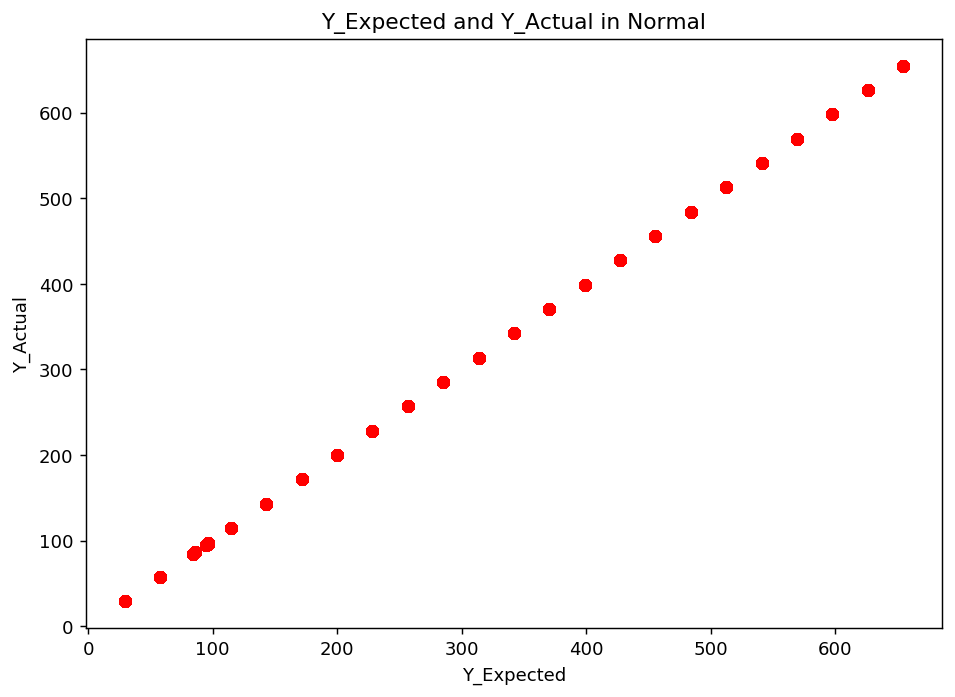

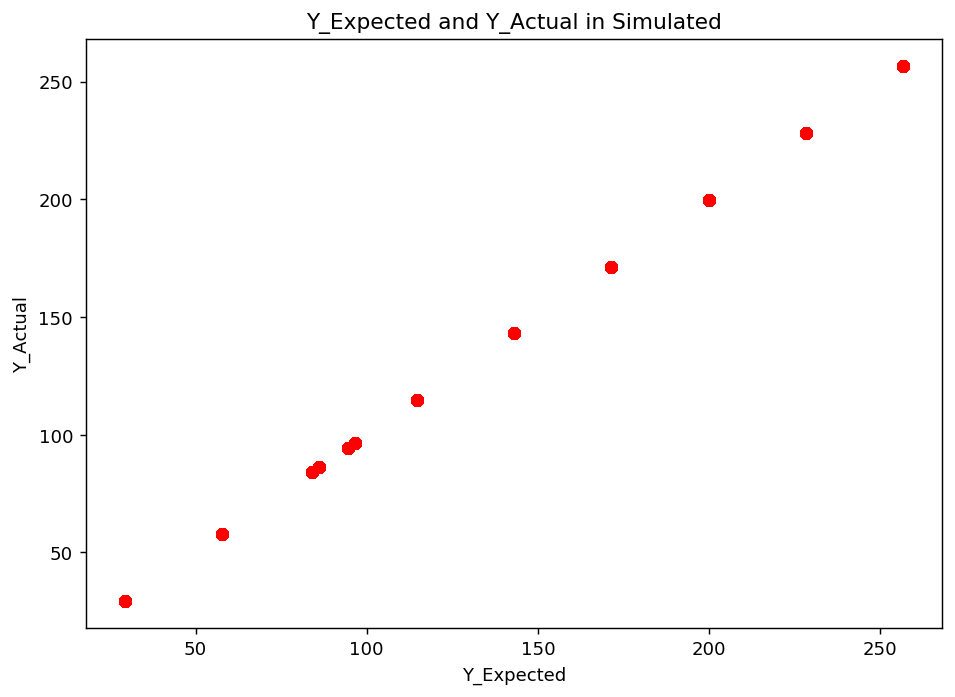

In [9]:

fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Expected_Location_Y"], df1["Actual_Location_Y"], 'ro' )
           

ax.set_title('Y_Expected and Y_Actual in Normal')
ax.set_xlabel('Y_Expected')
ax.set_ylabel('Y_Actual')

#ax.legend()

plt.show()


fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df2["Expected_Location_Y"], df2["Actual_Location_Y"], 'ro' )
           

ax.set_title('Y_Expected and Y_Actual in Simulated')
ax.set_xlabel('Y_Expected')
ax.set_ylabel('Y_Actual')

#ax.legend()

plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df1["Expected_Location_Y"], df1["Actual_Location_Y"],test_size=0.5,random_state=seed)

X_train=X_train.to_frame()

XX_train=np.c_[X_train, y_train]
#print(XX_train)


#print(df2["Expected_Location_Y"].shape)
frames_X=[X_test, df2["Expected_Location_Y"]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test, df2["Actual_Location_Y"]]
y_test_combo=pd.concat(frames_y, axis=0)
#print(X_test_combo)
X_test_combo=X_test_combo.to_frame()
y_test_combo=y_test_combo.to_frame()
#print(X_test_combo.shape)
#print(y_test_combo.shape)

XX_test_combo=np.c_[X_test_combo, y_test_combo]
#print(XX_test_combo)
#Build target variable
n2=X_test.shape[0]
#print(n2)
n3=df2["Expected_Location_Y"].shape[0]
#print(n3)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

y3=np.ones(n3, dtype=int)*(-1)
#print(y3.shape)
y_actual_test=np.r_[y2,y3]
#print(y_test.shape)

# fit the model Y_Expected
isf=IsolationForest()
isf.fit(X_train)
 #predict values
y_pred_train=isf.fit_predict(X_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(X_test_combo)
print(y_pred_test_combo)
# calculate metrics 
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both Y_Expected and Y_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 



[ 1 -1 -1 ...  1  1  1]
[ 1 -1  1 ...  1  1  1]
0.4797476759628154
0.45864661654135336
0.7514492753623189
0.5007246376811594
[[ 816 2448]
 [ 686 2074]]
[ 1 -1 -1 ...  1  1  1]
[ 1 -1  1 ...  1  1  1]
0.4797476759628154
0.45864661654135336
0.7514492753623189
0.5007246376811594
[[ 816 2448]
 [ 686 2074]]


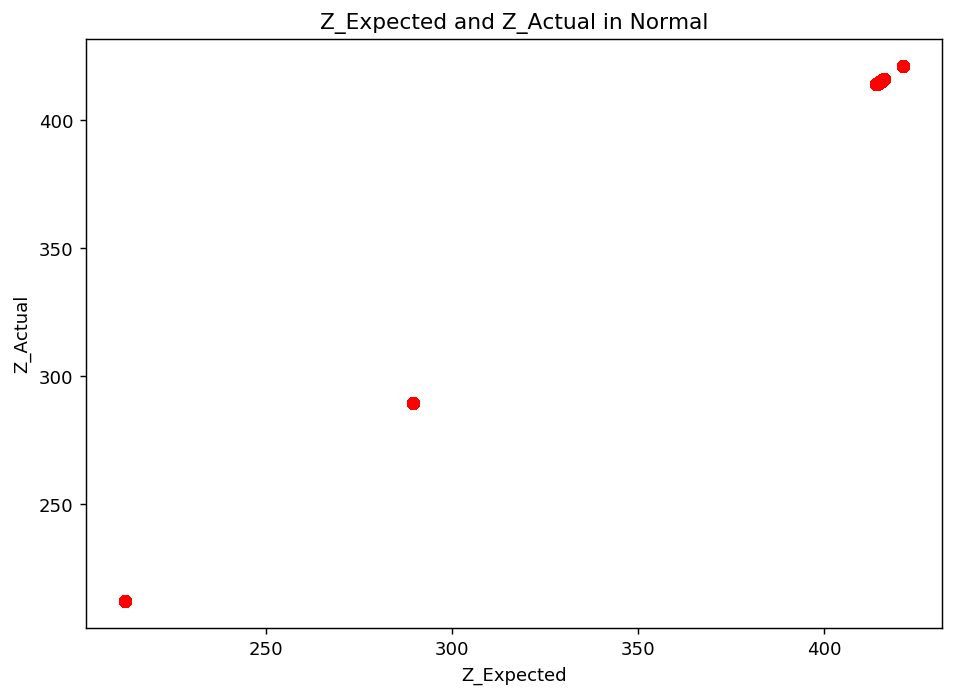

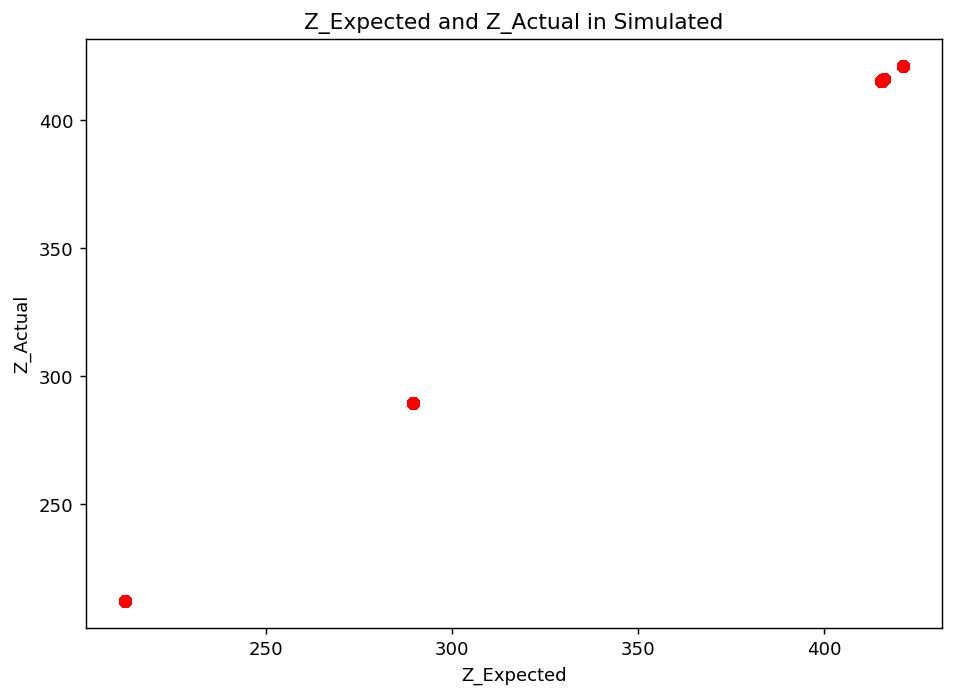

In [11]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Expected_Location_Z"], df1["Actual_Location_Z"], 'ro' )
           

ax.set_title('Z_Expected and Z_Actual in Normal')
ax.set_xlabel('Z_Expected')
ax.set_ylabel('Z_Actual')

#ax.legend()

plt.show()


fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df2["Expected_Location_Z"], df2["Actual_Location_Z"], 'ro' )
           

ax.set_title('Z_Expected and Z_Actual in Simulated')
ax.set_xlabel('Z_Expected')
ax.set_ylabel('Z_Actual')

#ax.legend()

plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df1["Expected_Location_Z"], df1["Actual_Location_Z"],test_size=0.5,random_state=seed)


X_train=X_train.to_frame()

XX_train=np.c_[X_train, y_train]
#print(XX_train)


#print(df2["Expected_Location_Z"].shape)
frames_X=[X_test, df2["Expected_Location_Z"]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test, df2["Actual_Location_Z"]]
y_test_combo=pd.concat(frames_y, axis=0)
#print(X_test_combo)
X_test_combo=X_test_combo.to_frame()
y_test_combo=y_test_combo.to_frame()
#print(X_test_combo.shape)
#print(y_test_combo.shape)

XX_test_combo=np.c_[X_test_combo, y_test_combo]
#print(XX_test_combo)
#Build target variable
n2=X_test.shape[0]
#print(n2)
n3=df2["Expected_Location_Z"].shape[0]
#print(n3)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

y3=np.ones(n3, dtype=int)*(-1)
#print(y3.shape)
y_actual_test=np.r_[y2,y3]
#print(y_test.shape)

# fit the model Z_Expected
isf=IsolationForest()
isf.fit(X_train)
 #predict values
y_pred_train=isf.fit_predict(X_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(X_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both Z_Expected and Z_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)
# calculate metrics 
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 



[-1 -1 -1 ... -1 -1 -1]
[-1 -1 -1 ... -1 -1 -1]
0.501660026560425
0.24686192468619247
0.042753623188405795
0.46622975277067347
[[2904  360]
 [2642  118]]
[ 1 -1 -1 ... -1 -1  1]
[ 1 -1 -1 ... -1  1  1]
0.5069721115537849
0.4612546125461255
0.4528985507246377
0.5027973145780051
[[1804 1460]
 [1510 1250]]


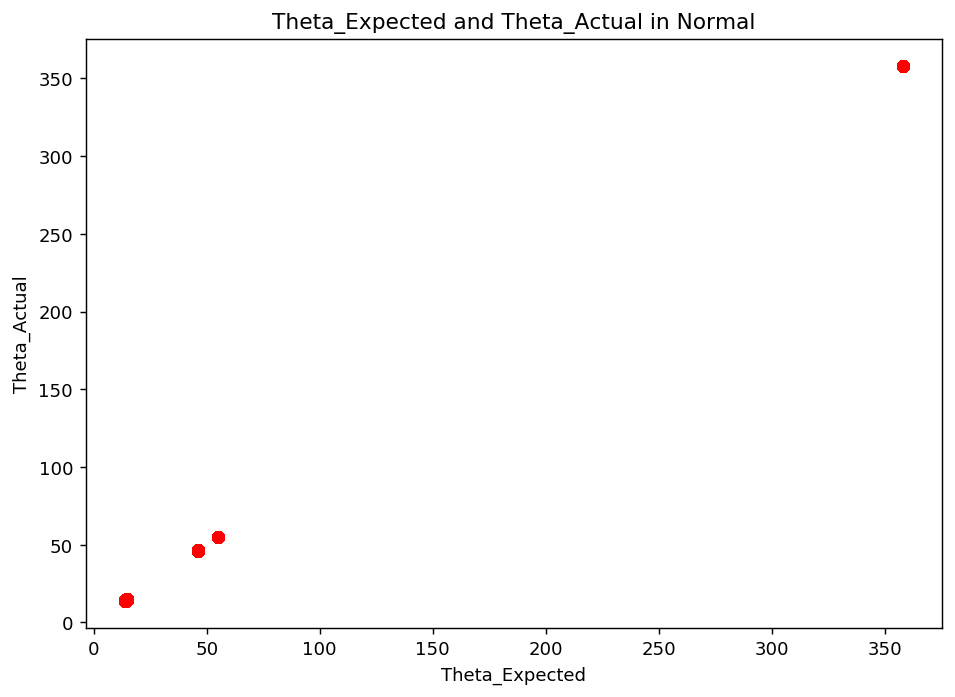

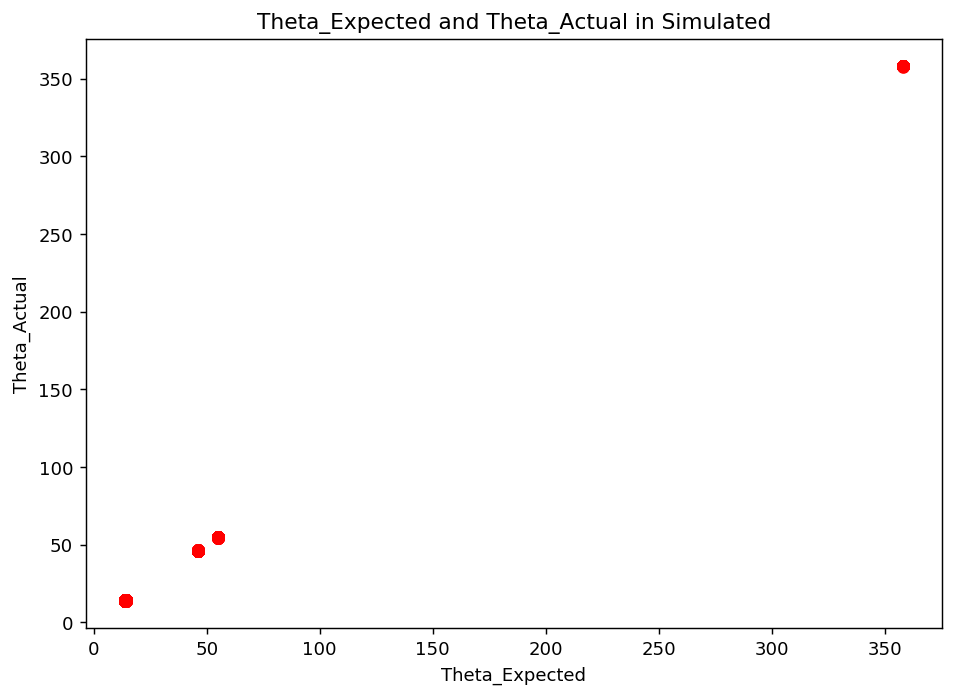

In [13]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Expected_Location_Theta"], df1["Actual_Location_Theta"], 'ro' )
           

ax.set_title('Theta_Expected and Theta_Actual in Normal')
ax.set_xlabel('Theta_Expected')
ax.set_ylabel('Theta_Actual')

#ax.legend()

plt.show()


fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df2["Expected_Location_Theta"], df2["Actual_Location_Theta"], 'ro' )
           

ax.set_title('Theta_Expected and Theta_Actual in Simulated')
ax.set_xlabel('Theta_Expected')
ax.set_ylabel('Theta_Actual')

#ax.legend()

plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df1["Expected_Location_Theta"], df1["Actual_Location_Theta"],test_size=0.5,random_state=seed)

X_train=X_train.to_frame()

XX_train=np.c_[X_train, y_train]
#print(XX_train)


#print(df2["Expected_Location_Theta"].shape)
frames_X=[X_test, df2["Expected_Location_Theta"]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test, df2["Actual_Location_Theta"]]
y_test_combo=pd.concat(frames_y, axis=0)
#print(X_test_combo)
X_test_combo=X_test_combo.to_frame()
y_test_combo=y_test_combo.to_frame()
#print(X_test_combo.shape)
#print(y_test_combo.shape)

XX_test_combo=np.c_[X_test_combo, y_test_combo]
#print(XX_test_combo)
#Build target variable
n2=X_test.shape[0]
#print(n2)
n3=df2["Expected_Location_Theta"].shape[0]
#print(n3)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

y3=np.ones(n3, dtype=int)*(-1)
#print(y3.shape)
y_actual_test=np.r_[y2,y3]
#print(y_test.shape)

# fit the model Theta_Expected
isf=IsolationForest()
isf.fit(X_train)
 #predict values
y_pred_train=isf.fit_predict(X_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(X_test_combo)
print(y_pred_test_combo)
# calculate metrics 
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both Theta_Expected and Theta_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 



[-1 -1 -1 ... -1  1 -1]
[-1 -1  1 ... -1  1  1]
0.49767596281540505
0.45560747663551404
0.4945652173913043
0.4974357949701619
[[1633 1631]
 [1395 1365]]
[-1 -1 -1 ... -1  1 -1]
[-1 -1  1 ... -1 -1 -1]
0.4955179282868526
0.45100105374077976
0.4652173913043478
0.4931785485933503
[[1701 1563]
 [1476 1284]]


# Actual Location and Motor Current

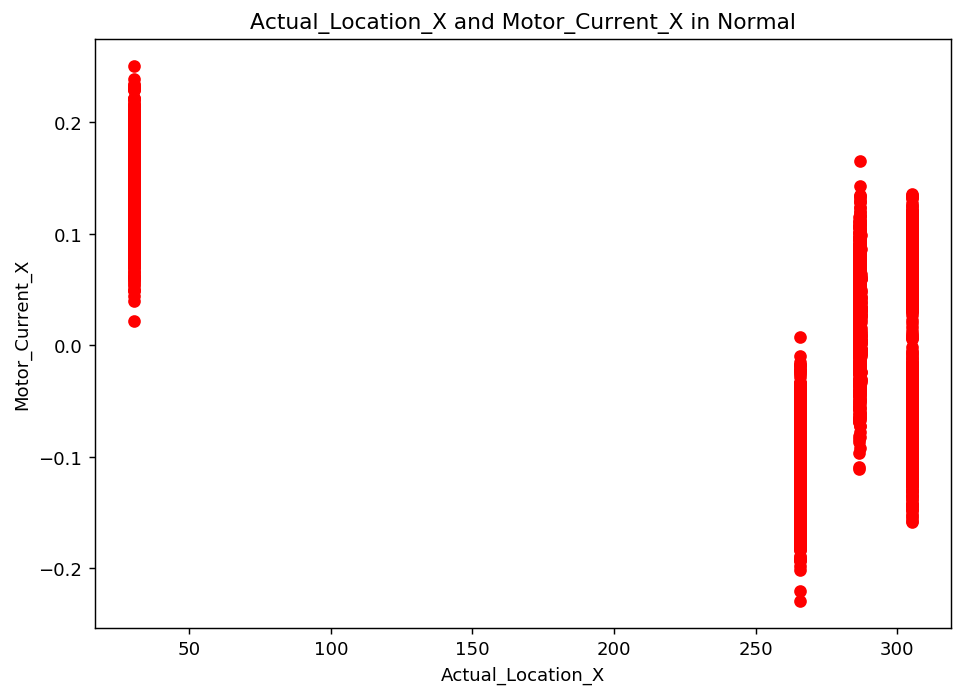

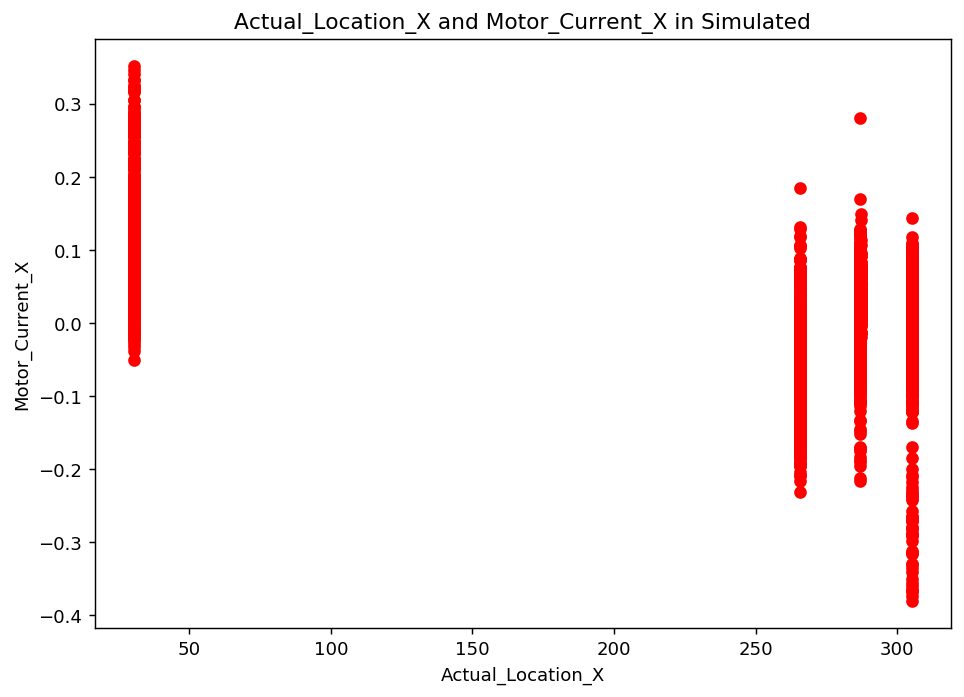

In [15]:
# Location and Motor Current
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Actual_Location_X"], df1["Motor_Current_X"], 'ro' )
           

ax.set_title('Actual_Location_X and Motor_Current_X in Normal')
ax.set_xlabel('Actual_Location_X')
ax.set_ylabel('Motor_Current_X')

#ax.legend()

plt.show()


fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df2["Actual_Location_X"], df2["Motor_Current_X"], 'ro' )
           

ax.set_title('Actual_Location_X and Motor_Current_X in Simulated')
ax.set_xlabel('Actual_Location_X')
ax.set_ylabel('Motor_Current_X')

#ax.legend()

plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df1["Actual_Location_X"], df1["Motor_Current_X"],test_size=0.5,random_state=seed)

X_train=X_train.to_frame()

XX_train=np.c_[X_train, y_train]
#print(XX_train)


#print(df2["Expected_Location_Theta"].shape)
frames_X=[X_test, df2["Actual_Location_X"]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test, df2["Motor_Current_X"]]
y_test_combo=pd.concat(frames_y, axis=0)
#print(X_test_combo)
X_test_combo=X_test_combo.to_frame()
y_test_combo=y_test_combo.to_frame()
#print(X_test_combo.shape)
#print(y_test_combo.shape)

XX_test_combo=np.c_[X_test_combo, y_test_combo]
#print(XX_test_combo)
#Build target variable
n2=X_test.shape[0]
#print(n2)
n3=df2["Actual_Location_X"].shape[0]
#print(n3)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

y3=np.ones(n3, dtype=int)*(-1)
#print(y3.shape)
y_actual_test=np.r_[y2,y3]
#print(y_test.shape)

# fit the model X_Expected
isf=IsolationForest()
isf.fit(X_train)
 #predict values
y_pred_train=isf.fit_predict(X_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(X_test_combo)
print(y_pred_test_combo)
# calculate metrics 
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both X_Expected and X_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 



[-1 -1 -1 ... -1 -1  1]
[ 1 -1 -1 ... -1  1 -1]
0.4098605577689243
0.3816612086930634
0.4644927536231884
0.4140784846547315
[[1187 2077]
 [1478 1282]]
[ 1 -1  1 ... -1 -1  1]
[ 1  1 -1 ... -1  1 -1]
0.5151062416998672
0.4817336056274109
0.7692028985507247
0.5347239982949702
[[ 980 2284]
 [ 637 2123]]


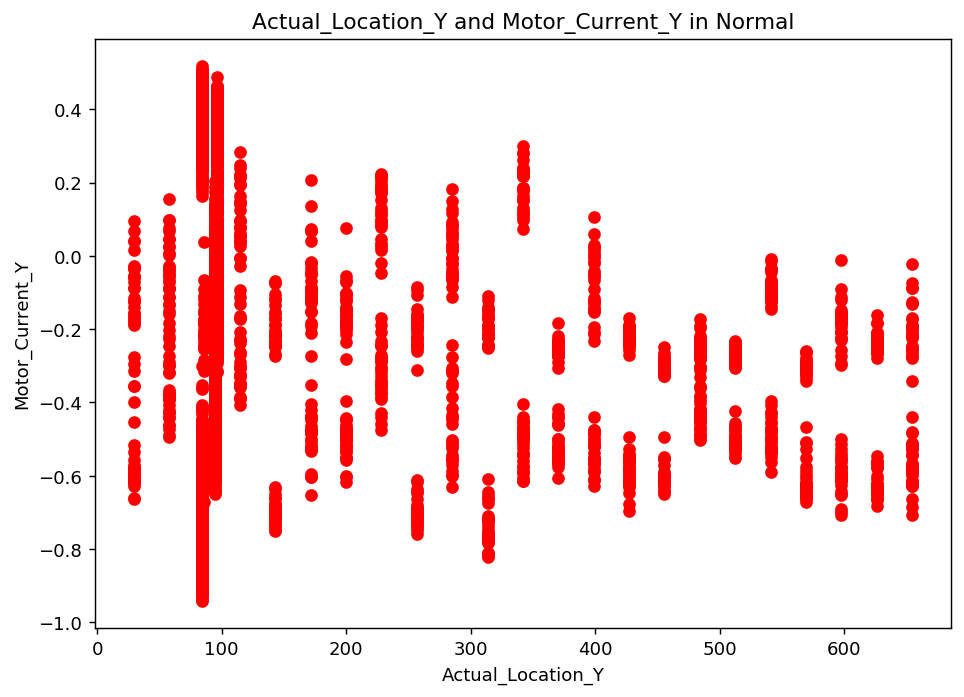

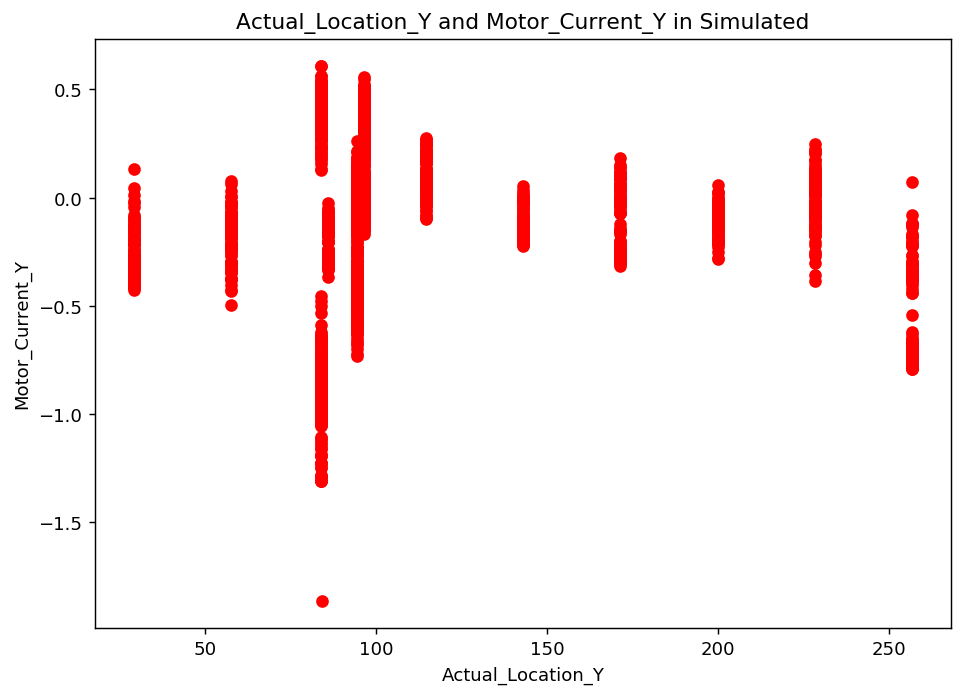

In [17]:
# Location and Motor Current
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Actual_Location_Y"], df1["Motor_Current_Y"], 'ro' )
           

ax.set_title('Actual_Location_Y and Motor_Current_Y in Normal')
ax.set_xlabel('Actual_Location_Y')
ax.set_ylabel('Motor_Current_Y')

#ax.legend()

plt.show()


fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df2["Actual_Location_Y"], df2["Motor_Current_Y"], 'ro' )
           

ax.set_title('Actual_Location_Y and Motor_Current_Y in Simulated')
ax.set_xlabel('Actual_Location_Y')
ax.set_ylabel('Motor_Current_Y')

#ax.legend()

plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df1["Actual_Location_Y"], df1["Motor_Current_Y"],test_size=0.5,random_state=seed)

X_train=X_train.to_frame()

XX_train=np.c_[X_train, y_train]
#print(XX_train)


#print(df2["Expected_Location_Theta"].shape)
frames_X=[X_test, df2["Actual_Location_Y"]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test, df2["Motor_Current_Y"]]
y_test_combo=pd.concat(frames_y, axis=0)
#print(X_test_combo)
X_test_combo=X_test_combo.to_frame()
y_test_combo=y_test_combo.to_frame()
#print(X_test_combo.shape)
#print(y_test_combo.shape)

XX_test_combo=np.c_[X_test_combo, y_test_combo]
#print(XX_test_combo)
#Build target variable
n2=X_test.shape[0]
#print(n2)
n3=df2["Actual_Location_Y"].shape[0]
#print(n3)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

y3=np.ones(n3, dtype=int)*(-1)
#print(y3.shape)
y_actual_test=np.r_[y2,y3]
#print(y_test.shape)

# fit the model Y_Expected
isf=IsolationForest()
isf.fit(X_train)
 #predict values
y_pred_train=isf.fit_predict(X_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(X_test_combo)
print(y_pred_test_combo)
# calculate metrics 
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both Y_Expected and Y_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 



[ 1 -1 -1 ...  1  1  1]
[ 1 -1  1 ...  1  1  1]
0.4797476759628154
0.45864661654135336
0.7514492753623189
0.5007246376811594
[[ 816 2448]
 [ 686 2074]]
[ 1 -1 -1 ...  1  1 -1]
[ 1 -1  1 ...  1  1  1]
0.47460159362549803
0.4572694661320954
0.7851449275362319
0.4985773657289003
[[ 692 2572]
 [ 593 2167]]


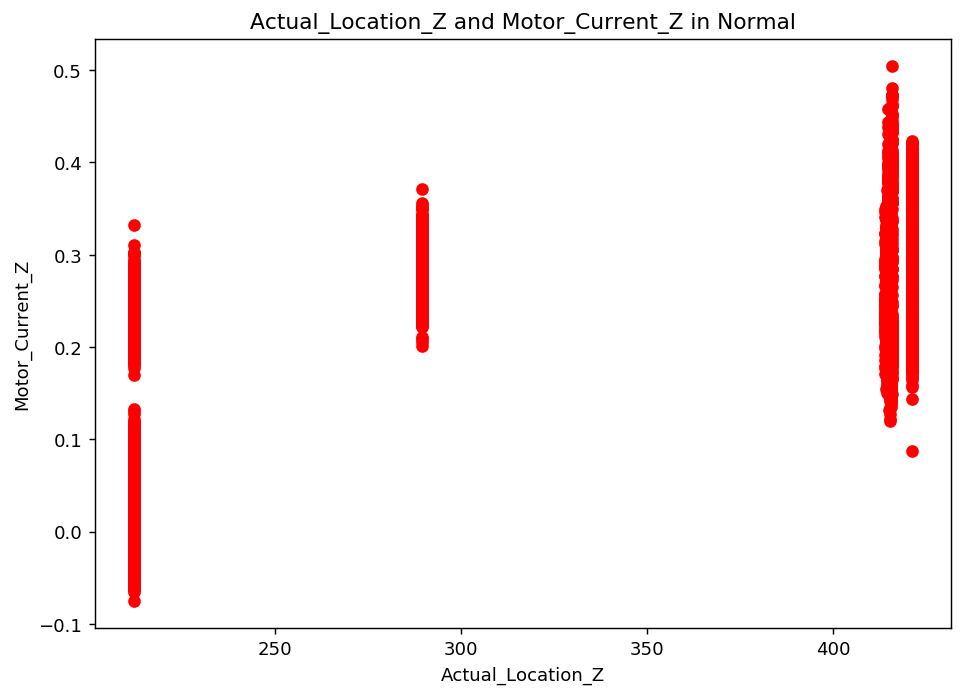

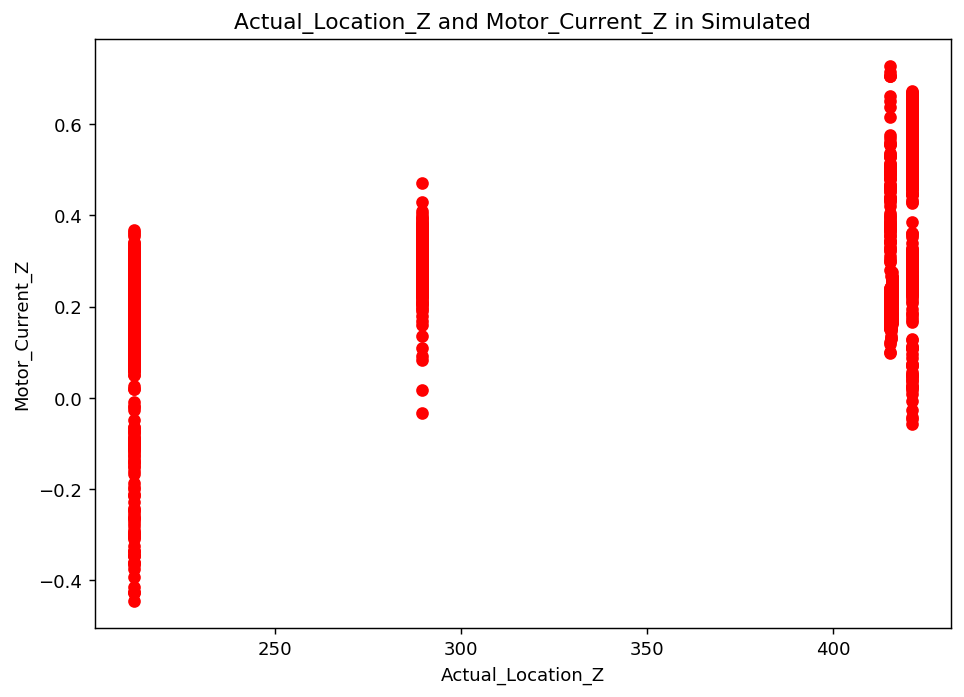

In [19]:
# Location and Motor Current
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Actual_Location_Z"], df1["Motor_Current_Z"], 'ro' )
           

ax.set_title('Actual_Location_Z and Motor_Current_Z in Normal')
ax.set_xlabel('Actual_Location_Z')
ax.set_ylabel('Motor_Current_Z')

#ax.legend()

plt.show()


fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df2["Actual_Location_Z"], df2["Motor_Current_Z"], 'ro' )
           

ax.set_title('Actual_Location_Z and Motor_Current_Z in Simulated')
ax.set_xlabel('Actual_Location_Z')
ax.set_ylabel('Motor_Current_Z')

#ax.legend()

plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df1["Actual_Location_Z"], df1["Motor_Current_Z"],test_size=0.5,random_state=seed)

X_train=X_train.to_frame()

XX_train=np.c_[X_train, y_train]
#print(XX_train)


#print(df2["Expected_Location_Theta"].shape)
frames_X=[X_test, df2["Actual_Location_Z"]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test, df2["Motor_Current_Z"]]
y_test_combo=pd.concat(frames_y, axis=0)
#print(X_test_combo)
X_test_combo=X_test_combo.to_frame()
y_test_combo=y_test_combo.to_frame()
#print(X_test_combo.shape)
#print(y_test_combo.shape)

XX_test_combo=np.c_[X_test_combo, y_test_combo]
#print(XX_test_combo)
#Build target variable
n2=X_test.shape[0]
#print(n2)
n3=df2["Actual_Location_Z"].shape[0]
#print(n3)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

y3=np.ones(n3, dtype=int)*(-1)
#print(y3.shape)
y_actual_test=np.r_[y2,y3]
#print(y_test.shape)

# fit the model Z_Expected
isf=IsolationForest()
isf.fit(X_train)
 #predict values
y_pred_train=isf.fit_predict(X_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(X_test_combo)
print(y_pred_test_combo)
# calculate metrics 
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both Z_Expected and Z_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 



[ 1 -1 -1 ... -1 -1  1]
[ 1 -1 -1 ... -1  1 -1]
0.5180942895086321
0.4709467696058513
0.41992753623188406
0.5105152387041774
[[1962 1302]
 [1601 1159]]
[ 1 -1  1 ...  1  1 -1]
[ 1  1  1 ... -1  1  1]
0.476593625498008
0.4501142421934501
0.6423913043478261
0.4893941815856777
[[1098 2166]
 [ 987 1773]]


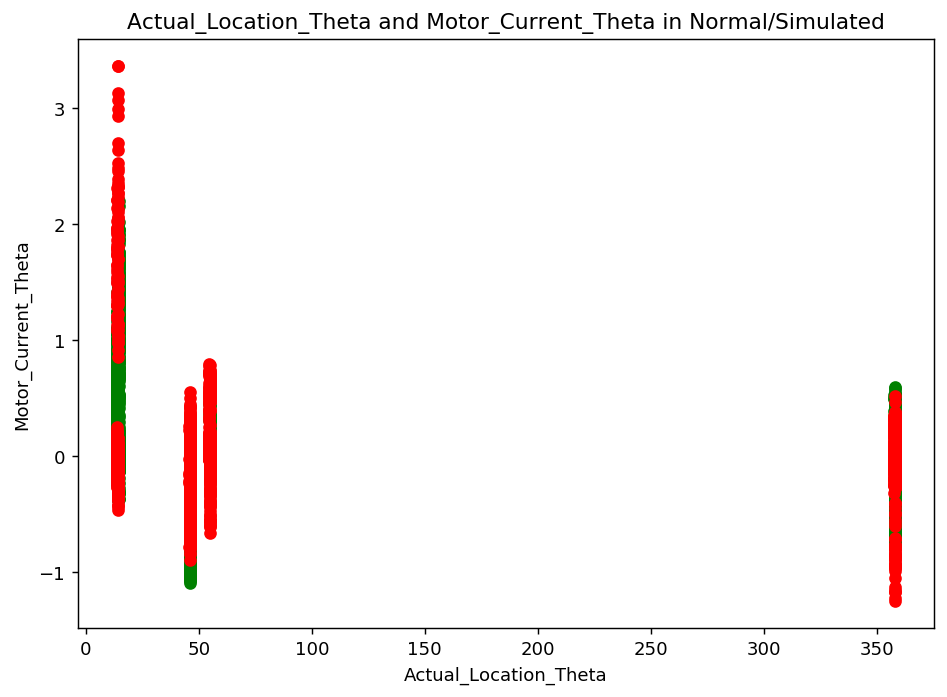

In [21]:
# Location and Motor Current
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Actual_Location_Theta"], df1["Motor_Current_Theta"], 'go' )
ax.plot(df2["Actual_Location_Theta"], df2["Motor_Current_Theta"], 'ro' )           

ax.set_title('Actual_Location_Theta and Motor_Current_Theta in Normal/Simulated')
ax.set_xlabel('Actual_Location_Theta')
ax.set_ylabel('Motor_Current_Theta')

#ax.legend()



plt.show()

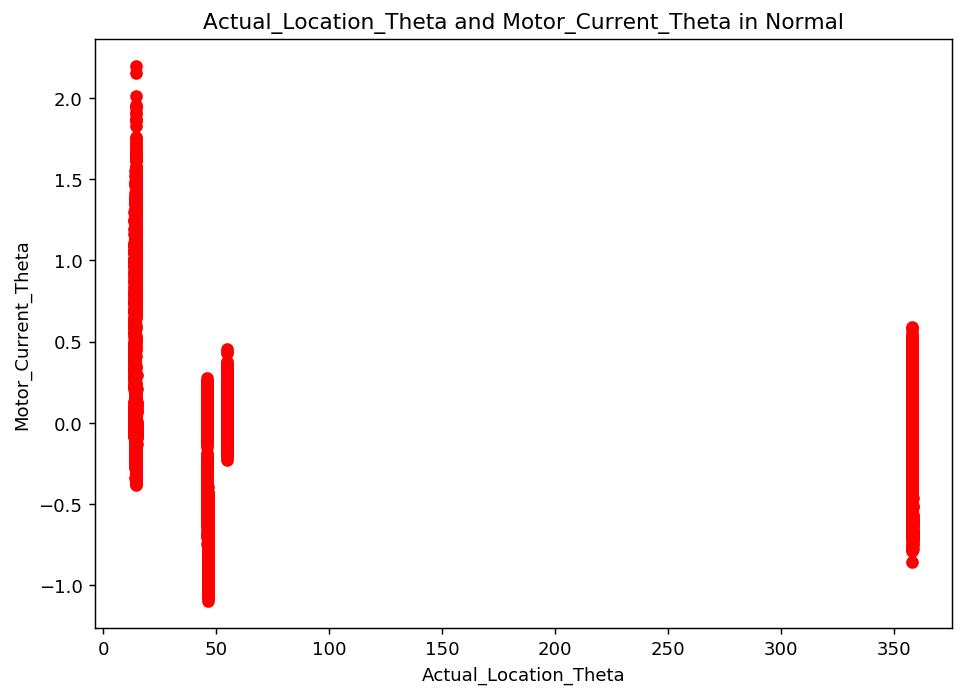

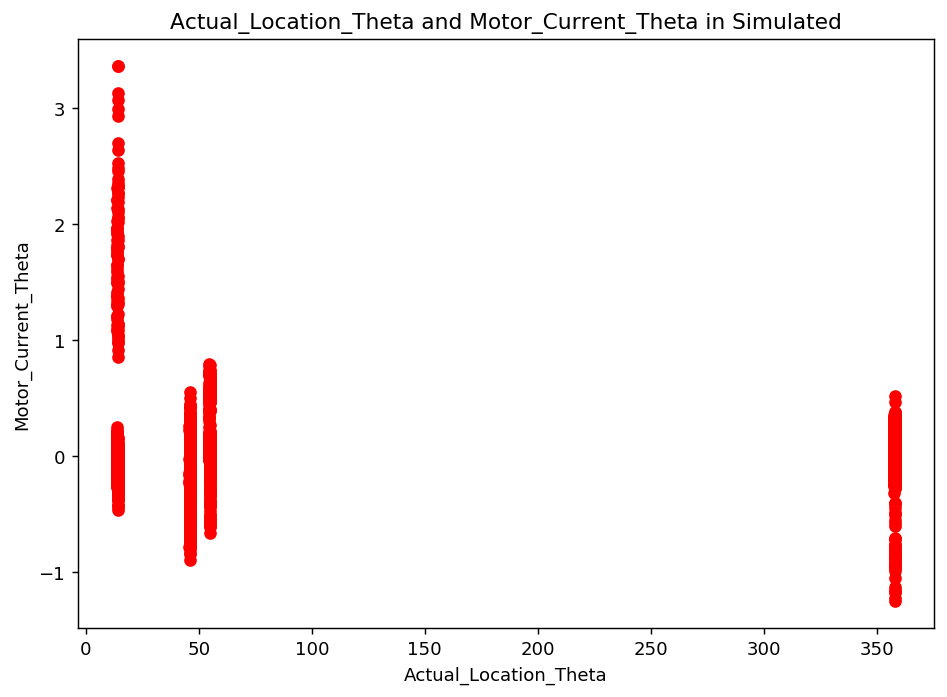

In [22]:
# Location and Motor Current
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df1["Actual_Location_Theta"], df1["Motor_Current_Theta"], 'ro' )
           

ax.set_title('Actual_Location_Theta and Motor_Current_Theta in Normal')
ax.set_xlabel('Actual_Location_Theta')
ax.set_ylabel('Motor_Current_Theta')

#ax.legend()

plt.show()


fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)



ax.plot(df2["Actual_Location_Theta"], df2["Motor_Current_Theta"], 'ro' )
           

ax.set_title('Actual_Location_Theta and Motor_Current_Theta in Simulated')
ax.set_xlabel('Actual_Location_Theta')
ax.set_ylabel('Motor_Current_Theta')

#ax.legend()

plt.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df1["Actual_Location_Theta"], df1["Motor_Current_Theta"],test_size=0.5,random_state=seed)

X_train=X_train.to_frame()

XX_train=np.c_[X_train, y_train]
#print(XX_train)


#print(df2["Expected_Location_Theta"].shape)
frames_X=[X_test, df2["Actual_Location_Theta"]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test, df2["Motor_Current_Theta"]]
y_test_combo=pd.concat(frames_y, axis=0)
#print(X_test_combo)
X_test_combo=X_test_combo.to_frame()
y_test_combo=y_test_combo.to_frame()
#print(X_test_combo.shape)
#print(y_test_combo.shape)

XX_test_combo=np.c_[X_test_combo, y_test_combo]
#print(XX_test_combo)
#Build target variable
n2=X_test.shape[0]
#print(n2)
n3=df2["Actual_Location_Theta"].shape[0]
#print(n3)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

y3=np.ones(n3, dtype=int)*(-1)
#print(y3.shape)
y_actual_test=np.r_[y2,y3]
#print(y_test.shape)

# fit the model Theta_Expected
isf=IsolationForest()
isf.fit(X_train)
 #predict values
y_pred_train=isf.fit_predict(X_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(X_test_combo)
print(y_pred_test_combo)
# calculate metrics 
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both Theta_Expected and Theta_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)
# calculate metrics
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 



[-1 -1  1 ... -1  1 -1]
[-1 -1  1 ... -1 -1 -1]
0.47443559096945553
0.4314189189189189
0.46268115942028987
0.4735280797101449
[[1581 1683]
 [1483 1277]]
[ 1 -1 -1 ...  1  1 -1]
[ 1 -1  1 ... -1  1  1]
0.4304448871181939
0.41854819130857
0.6246376811594203
0.44543771312872976
[[ 869 2395]
 [1036 1724]]


# Using actual location and gripper force

In [32]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(df1.iloc[:, 10:14], df1["Gripper Force (%)"],test_size=0.5,random_state=seed)

#X_train=X_train.to_frame()

XX_train=np.c_[X_train_N, y_train_N]

frames_X=[X_test_N, df2.iloc[:, 10:14]]
X_test_combo=pd.concat(frames_X, axis=0)

frames_y=[y_test_N, df2["Gripper Force (%)"]]
y_test_combo=pd.concat(frames_y, axis=0)

#X_test_combo=X_test_combo.to_frame()
#y_test_combo=y_test_combo.to_frame()
#Combining both all the four coordinates of actual location and gripper force
XX_train=np.c_[X_train_N, y_train_N]
XX_test_combo=np.c_[X_test_combo, y_test_combo]

#Build the requisite number of target labels-Number of such target lables will equal no of data points in the test data
# Target lable is as 1 if the data point belongs to normal operation and -1 if the data point  belongs to simulated degradation
# case of 50% of the remaining normal operation being used as test data
n2=X_test_N.shape[0]
#print(n2)
y2=np.ones(n2, dtype=int)
#print(y2.shape)

# case of simulated degradation being used as test data
n3=df2["Gripper Force (%)"].shape[0]
#print(n3)
y3=np.ones(n3, dtype=int)*(-1)
# making a combined list target lables for normal operation and simulated degradation data
y_actual_test=np.r_[y2,y3]

# fit/train the model on all 4 coordinates of actual location
isf=IsolationForest()
isf.fit(X_train_N)
#predict labels(inlier(1) or outlier(-1)) for X_train( 4 coordinates of actual location of 50% normal operation data)
y_pred_train=isf.fit_predict(X_train_N) 

#predict values for 4 coordinates of actual location of the remaining 50% normal operation data
y_pred_test_combo=isf.fit_predict(X_test_combo)



# calculate metrics on the basis of target lables and predicted labels when the remaning 50% normal operation data is the test data
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 

# fit the model on both Theta_Expected and Theta_Actual 
isf=IsolationForest()
isf.fit(XX_train)
 #predict values
y_pred_train=isf.fit_predict(XX_train) 
print(y_pred_train)
y_pred_test_combo=isf.fit_predict(XX_test_combo)
print(y_pred_test_combo)

# calculate metrics on the basis of target lables and predicted labels when simulated degradation data is the test data
print(accuracy_score(y_actual_test, y_pred_test_combo))
print(precision_score(y_actual_test, y_pred_test_combo))
print(recall_score(y_actual_test, y_pred_test_combo))
print(roc_auc_score(y_actual_test, y_pred_test_combo)) 
print(confusion_matrix (y_actual_test, y_pred_test_combo)) 






0.48389774236387784
0.4559232129325587
0.6539855072463768
0.4970295183290708
[[1110 2154]
 [ 955 1805]]
[ 1 -1 -1 ...  1 -1 -1]
[ 1 -1  1 ... -1  1  1]
0.4633134130146082
0.4465053155394707
0.7152173913043478
0.48276188192668373
[[ 817 2447]
 [ 786 1974]]
